## SIIM ISIC MELANOMA DETECTION - Analysis using Logistic Regression

### I have used Logistic regression because our dataset can be classified in the form of Dichotonous variable i.e. 0 for benign and 1 for malignant images in context of this Dataset. 

### If you have any doubts or need explaination, you can reach me at khurana.d@northeastern.edu

---------------------------------------------------------------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd 
import gc
import json
import math
import cv2
import PIL
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA
import os
import imagesize

%matplotlib inline

In [3]:
import os
print(os.listdir("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification"))

['x_test_96.npy', 'x_train_32.npy', '.DS_Store', 'test', 'x_train_128.npy', 'test.csv', 'x_train_96.npy', 'x_test_32.npy', 'x_test_128.npy', 'datasets_680899_1200702_x_train_64.npy', 'train', 'train.csv', 'jpeg', 'x_test_224.npy', 'x_test_64.npy', 'tfrecords', 'x_train_224.npy', 'sample_submission.csv']


In [4]:
#Loading Train and Test Data
train = pd.read_csv("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/train.csv")
test = pd.read_csv("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/test.csv")
print("{} images in train set.".format(train.shape[0]))
print("{} images in test set.".format(test.shape[0]))

33126 images in train set.
10982 images in test set.


In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [7]:
train.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [8]:
# Drop missing values
train = train.dropna()

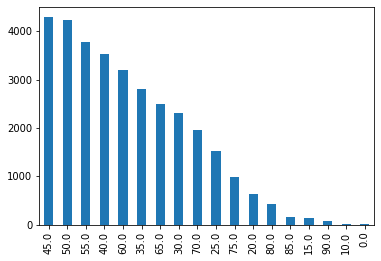

In [9]:
train['age_approx'].value_counts().plot(kind='bar')

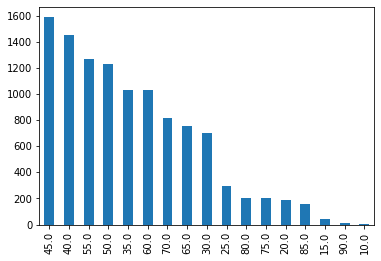

In [10]:
test['age_approx'].value_counts().plot(kind='bar')

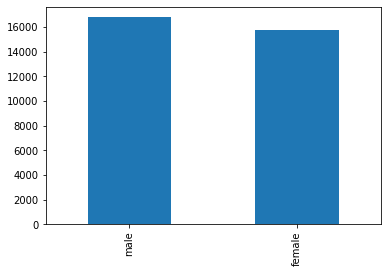

In [11]:
train['sex'].value_counts().plot(kind='bar')

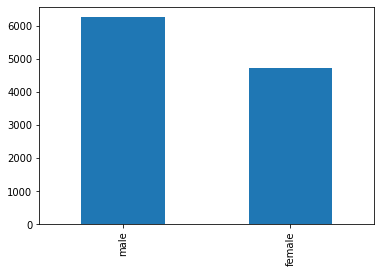

In [12]:
test['sex'].value_counts().plot(kind='bar')

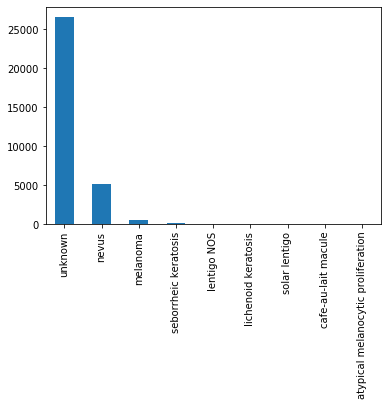

In [13]:
train['diagnosis'].value_counts().plot(kind='bar')

In [14]:
np.mean(train.target)

0.017675448034182778

### The data is Highly Imbalanced

## Let's now look at the distributions of various "features"

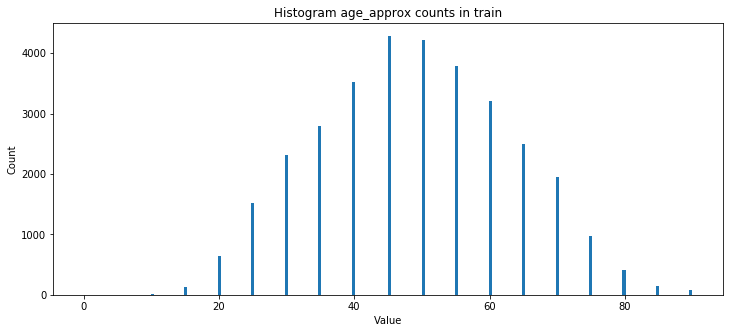

In [15]:
plt.figure(figsize=(12, 5))
plt.hist(train['age_approx'].values, bins=200)
plt.title('Histogram age_approx counts in train')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

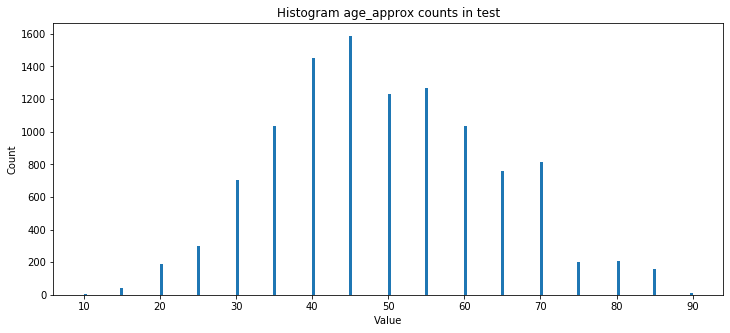

In [16]:
plt.figure(figsize=(12, 5))
plt.hist(test['age_approx'].values, bins=200)
plt.title('Histogram age_approx counts in test')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

EDA

In [17]:
# Display proportion of benign and malignant melanomas
train.benign_malignant.value_counts(normalize = True)

benign       0.982325
malignant    0.017675
Name: benign_malignant, dtype: float64

In [18]:
# Checking in which body part Cancer is more common ?
grp = train.groupby(['anatom_site_general_challenge']).mean().sort_values(by = 'target')
grp

,age_approx,target
anatom_site_general_challenge,,
palms/soles,44.346667,0.013333
lower extremity,49.074890,0.014764
torso,48.723031,0.015275
upper extremity,48.516019,0.022366
oral/genital,44.354839,0.032258
head/neck,52.295393,0.040108


In [19]:
%matplotlib inline

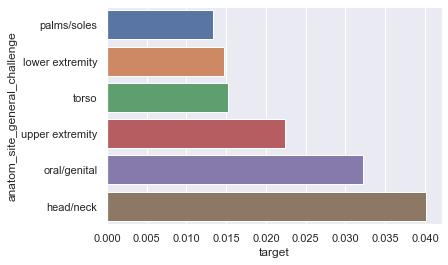

In [20]:
import seaborn as sns
sns.set(style="darkgrid")
# titanic = sns.load_dataset("titanic")
ax = sns.barplot(x="target", y=grp.index, data=grp)
# plt.bar( grp.index , grp['target'])

In [22]:
train.fillna("NA").groupby(['sex','anatom_site_general_challenge'])['target'].aggregate(['sum','count','mean']).reset_index().style.background_gradient(cmap='Reds')

,sex,anatom_site_general_challenge,sum,count,mean
0,female,head/neck,20,832,0.0240385
1,female,lower extremity,58,4449,0.0130366
2,female,oral/genital,3,45,0.0666667
3,female,palms/soles,1,151,0.00662252
4,female,torso,85,7579,0.0112152
5,female,upper extremity,50,2687,0.0186081
6,male,head/neck,54,1013,0.053307
7,male,lower extremity,66,3950,0.0167089
8,male,oral/genital,1,79,0.0126582
9,male,palms/soles,4,224,0.0178571


In [ ]:
images = []
for i, image_id in enumerate(tqdm(train['image_name'].head(10))):
    im = Image.open(f'../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/jpeg/train/{image_id}.jpg')
    im = im.resize((128, )*2, resample=Image.LANCZOS)
    images.append(im)

In [ ]:
images[0]

In [ ]:
images[5]

In [ ]:
images= train['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/jpeg/train'

print('Display random images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

In [ ]:
benign = train[train['benign_malignant']=='benign']
malignant = train[train['benign_malignant']=='malignant']

In [ ]:
images= benign['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/jpeg/train'

print('Display Benign images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

In [ ]:
images= malignant['image_name'].values

#extract 9 random images
import random
random_images = [np.random.choice(images + '.jpg') for i in range(9)]

#location of image dir 
image_dir = '../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/jpeg/train'

print('Display Malignant images')

#iterate and plot images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(image_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout() 

In [ ]:
x_train_32 = np.load("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/x_train_32.npy")
x_test_32 = np.load("../Adv_Data_Science_Final_Project/siim-isic-melanoma-classification/x_test_32.npy")

In [ ]:
x_train_32.shape

In [ ]:
x_train_32 = x_train_32.reshape((x_train_32.shape[0], 32*32*3))
x_train_32.shape

In [ ]:
x_test_32 = x_test_32.reshape((x_test_32.shape[0], 32*32*3))
x_test_32.shape

In [ ]:
y = train.target.values

In [ ]:
train_oof = np.zeros((x_train_32.shape[0], ))
test_preds = 0
train_oof.shape

In [ ]:
x_train_32

## Logistic Regression

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(x_train_32)):
    print("Fitting fold", jj+1)
    train_features = x_train_32[train_index]
    train_target = y[train_index]
    
    val_features = x_train_32[val_index]
    val_target = y[val_index]
    
    model = LogisticRegression(C=1, solver='lbfgs', multi_class='multinomial', max_iter=60)
    model.fit(train_features, train_target)
    val_pred = model.predict_proba(val_features)[:,1]
    train_oof[val_index] = val_pred
    print(len(train_oof))
    print("Fold AUC:", roc_auc_score(val_target, val_pred))
    test_preds += model.predict_proba(x_test_32)[:,1]/n_splits
    del train_features, train_target, val_features, val_target
    gc.collect()

In [ ]:
print(roc_auc_score(y, train_oof))

In [ ]:
train['age_approx'].unique()

In [ ]:
train['sex'] = (train['sex'].values == 'male')*1
test['sex'] = (test['sex'].values == 'male')*1
train.head()

In [ ]:
test.head()

In [ ]:
train['sex'].mean()

In [ ]:
test['sex'].mean()

In [ ]:
train['age_approx'].mean()

In [ ]:
test['age_approx'].mean()

In [ ]:
# Filling missing values
train['age_approx'] = train['age_approx'].fillna(train['age_approx'].mean())
test['age_approx'] = test['age_approx'].fillna(test['age_approx'].mean())

In [ ]:
x_train_32 = np.hstack([x_train_32, train['sex'].values.reshape(-1,1), train['age_approx'].values.reshape(-1,1)])
x_test_32 = np.hstack([x_test_32, test['sex'].values.reshape(-1,1), test['age_approx'].values.reshape(-1,1)])

In [ ]:
x_train_32[0].shape

In [ ]:
#Cleaning data for input
train['anatom_site_general_challenge'].unique()

test['anatom_site_general_challenge'].unique()

train['anatom_site_general_challenge'].mode()

test['anatom_site_general_challenge'].mode()

train['anatom_site_general_challenge'].fillna(train['anatom_site_general_challenge'].mode(), inplace=True)
test['anatom_site_general_challenge'].fillna(test['anatom_site_general_challenge'].mode(), inplace=True)

train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].astype(str)
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].astype(str)

In [ ]:
#Training with Image and tabular data'
train_oof_3 = np.zeros((x_train_32.shape[0], ))
test_preds_3 = 0


n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(x_train_32)):
    print("Fitting fold", jj+1)
    train_features = x_train_32[train_index]
    train_target = y[train_index]
    
    val_features = x_train_32[val_index]
    val_target = y[val_index]
    
    model = LogisticRegression(C=1, solver='lbfgs', multi_class='multinomial', max_iter=60)
    model.fit(train_features, train_target)
    val_pred = model.predict_proba(val_features)[:,1]
    train_oof_3[val_index] = val_pred
    print("Fold AUC:", roc_auc_score(val_target, val_pred))
    test_preds_3 += model.predict_proba(x_test_32)[:,1]/n_splits
    del train_features, train_target, val_features, val_target
    gc.collect()

In [ ]:
ans = pd.DataFrame(train_oof_3)

In [ ]:
print(roc_auc_score(y, train_oof_3))